## Prediction Using ARIMA

In this section, we will use the ARIMA (AutoRegressive Integrated Moving Average) model to make predictions based on our time series data. ARIMA is a popular statistical method for forecasting future points in a series by considering its own past values, trends, and noise. 

We will follow these steps:
1. Prepare and visualize the time series data.
2. Fit the ARIMA model to the data.
3. Generate predictions and visualize the results.
4. Evaluate the model's performance.

### 1.- Prepare and visualize the time series data.

In this step, we prepare our dataset to analyze the demand for technical skills over time. We use the `created` column, which contains the posting date for each job, as our time variable. To analyze skill trends, we transform the `skills` column (which lists all mentioned technologies for each job) so that each skill appears in its own row. This allows us to count how many times each skill is mentioned per day.

By grouping the data by date and skill, we create a time series for each technology, showing its daily frequency in job postings. This pattern is essential for time series forecasting, as it enables us to observe trends, seasonality, and fluctuations in the demand for each skill over time. Visualizing these time series helps us identify which skills are most in demand and how their popularity evolves, providing a solid foundation for ARIMA-based forecasting.

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load your CSV
df = pd.read_csv('../data/processed/jalisco_bigtech_jobs_processed_20250603_220138.csv')

# List of mention columns to combine
mention_cols = [
    'mentions_python', 'mentions_java', 'mentions_javascript', 'mentions_react',
    'mentions_angular', 'mentions_node', 'mentions_sql', 'mentions_cloud',
    'mentions_machine_learning', 'mentions_docker', 'mentions_kubernetes', 'mentions_agile'
]

# Map column names to skill names
col_to_skill = {
    'mentions_python': 'python',
    'mentions_java': 'java',
    'mentions_javascript': 'javascript',
    'mentions_react': 'react',
    'mentions_angular': 'angular',
    'mentions_node': 'node',
    'mentions_sql': 'sql',
    'mentions_cloud': 'cloud',
    'mentions_machine_learning': 'machine learning',
    'mentions_docker': 'docker',
    'mentions_kubernetes': 'kubernetes',
    'mentions_agile': 'agile'
}

# Function to combine mentions into a single string
def combine_skills(row):
    return ', '.join([col_to_skill[col] for col in mention_cols if row[col] == True])

# Create the new 'skills' column
df['skills'] = df.apply(combine_skills, axis=1)

# Optionally, drop the original mention columns
df = df.drop(columns=mention_cols)

# Save or use df as needed
df.to_csv('../data/cleaned/jalisco_bigtech_jobs_cleaned.csv', index=False)


### 2.- Fit the ARIMA model to the data

To predict the most relevant skills over time, we will:

1. Aggregate the data to count the frequency of each skill by date.
2. Select the top skills for time series modeling.
3. Prepare a time series for each skill and fit an ARIMA model to forecast future trends.

This approach allows us to identify which technical skills are likely to become more in-demand in the near future based on historical job posting data.


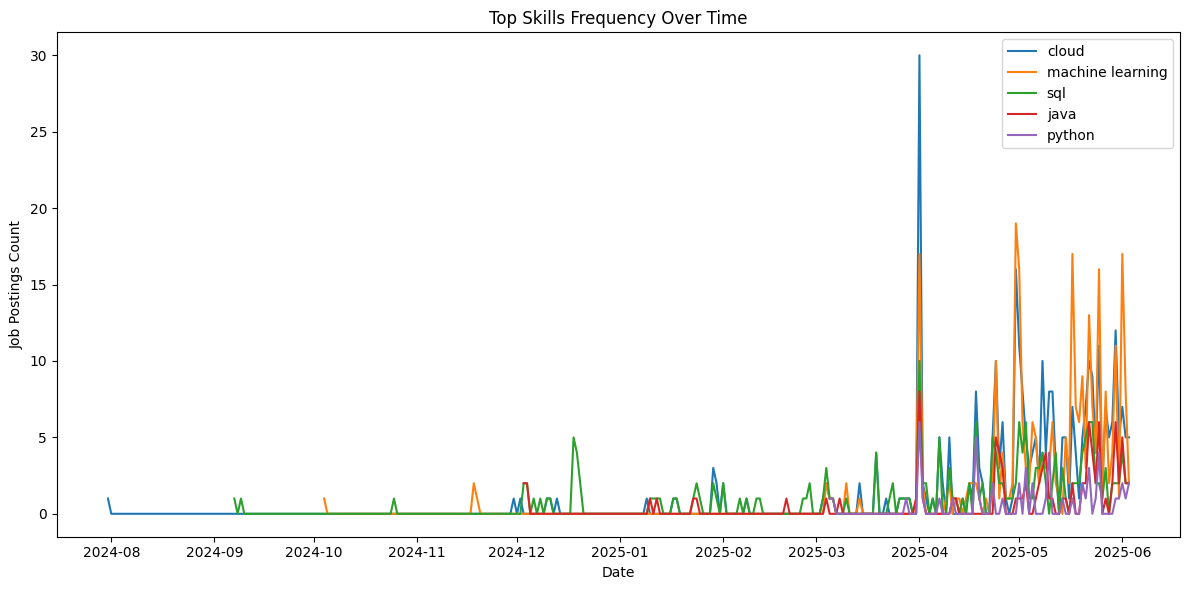

In [3]:
from collections import Counter

import matplotlib.pyplot as plt

df = pd.read_csv('../data/cleaned/jalisco_bigtech_jobs_cleaned.csv', parse_dates=['created'])

# 1. Aggregate the data to count the frequency of each skill by date
df['created_date'] = pd.to_datetime(df['created']).dt.date

# Explode the 'skills' column to have one skill per row
df_skills = df.copy()
df_skills['skills_list'] = df_skills['skills'].str.split(', ')
df_skills_exploded = df_skills.explode('skills_list')

# Group by date and skill, count occurrences
skill_counts = (
    df_skills_exploded.groupby(['created_date', 'skills_list'])
    .size()
    .reset_index(name='count')
)

# 2. Select the top N skills for time series modeling
top_n = 5
top_skills = (
    df_skills_exploded['skills_list']
    .value_counts()
    .head(top_n)
    .index.tolist()
)

# 3. Prepare a time series for each skill and plot
plt.figure(figsize=(12, 6))
for skill in top_skills:
    skill_ts = (
        skill_counts[skill_counts['skills_list'] == skill]
        .set_index('created_date')['count']
        .asfreq('D', fill_value=0)
        .sort_index()
    )
    plt.plot(skill_ts.index, skill_ts.values, label=skill)

plt.title('Top Skills Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Job Postings Count')
plt.legend()
plt.tight_layout()
plt.show()

### 3.- Generate predictions and visualize the results

In this step, we will fit an ARIMA model to the time series data for each of the top skills. We will then generate forecasts for future demand and visualize both the historical data and the predicted values. This will help us understand potential trends and anticipate which technical skills may become more relevant in the near future.

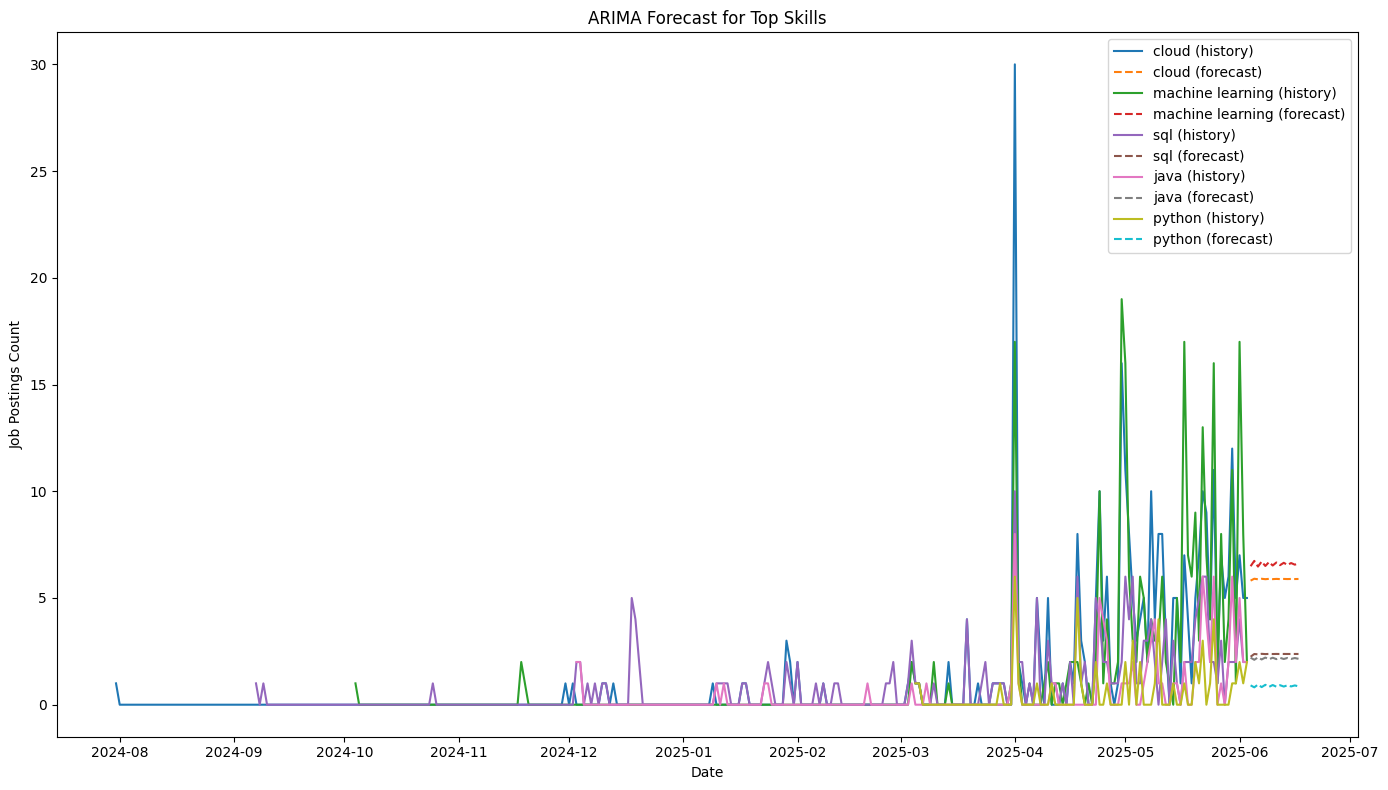

In [4]:
from statsmodels.tsa.arima.model import ARIMA

forecast_horizon = 14  # days to forecast

plt.figure(figsize=(14, 8))
for skill in top_skills:
    # Prepare the time series for the skill
    skill_ts = (
        skill_counts[skill_counts['skills_list'] == skill]
        .set_index('created_date')['count']
        .asfreq('D', fill_value=0)
        .sort_index()
    )
    # Convert index to datetime if needed
    if not isinstance(skill_ts.index, pd.DatetimeIndex):
        skill_ts.index = pd.to_datetime(skill_ts.index)

    # Fit ARIMA model (order can be tuned)
    model = ARIMA(skill_ts, order=(2, 1, 2))
    model_fit = model.fit()

    # Forecast
    forecast = model_fit.forecast(steps=forecast_horizon)
    forecast_index = pd.date_range(skill_ts.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')

    # Plot historical and forecast
    plt.plot(skill_ts.index, skill_ts.values, label=f"{skill} (history)")
    plt.plot(forecast_index, forecast, '--', label=f"{skill} (forecast)")

plt.title('ARIMA Forecast for Top Skills')
plt.xlabel('Date')
plt.ylabel('Job Postings Count')
plt.legend()
plt.tight_layout()
plt.show()

#### 4.- Evaluate the model's performance

To evaluate the ARIMA model's forecasting accuracy for each skill, we can use metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). This involves comparing the model's predictions on a hold-out (test) set with the actual observed values. A typical approach is to split the time series into training and test sets, fit the model on the training data, and evaluate predictions on the test data. Lower error values indicate better model performance.

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate ARIMA model performance for each top skill
results = []
test_size = 14  # Use the same as forecast_horizon

for skill in top_skills:
    # Prepare the time series for the skill
    skill_ts = (
        skill_counts[skill_counts['skills_list'] == skill]
        .set_index('created_date')['count']
        .asfreq('D', fill_value=0)
        .sort_index()
    )
    # Convert index to datetime if needed
    if not isinstance(skill_ts.index, pd.DatetimeIndex):
        skill_ts.index = pd.to_datetime(skill_ts.index)

    # Split into train and test
    train, test = skill_ts[:-test_size], skill_ts[-test_size:]

    # Fit ARIMA model on training data
    model = ARIMA(train, order=(2, 1, 2))
    model_fit = model.fit()

    # Forecast for test period
    forecast = model_fit.forecast(steps=test_size)

    # Calculate metrics
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))

    results.append({'skill': skill, 'MAE': mae, 'RMSE': rmse})

# Display results
results_df = pd.DataFrame(results)
print(results_df)

              skill       MAE      RMSE
0             cloud  2.870789  3.702987
1  machine learning  4.547689  5.527215
2               sql  1.238424  1.831110
3              java  1.863927  2.488031
4            python  0.981890  1.315876


This table summarizes the ARIMA model's forecasting performance for the top 5 technical skills, using two common error metrics:

- **MAE (Mean Absolute Error):** The average absolute difference between the predicted and actual job posting counts. Lower values indicate better accuracy.
- **RMSE (Root Mean Squared Error):** The square root of the average squared differences between predicted and actual values. It penalizes larger errors more than MAE.

**Interpretation:**
- **Python** has the lowest MAE (0.98) and RMSE (1.32), meaning the model predicts its demand most accurately.
- **Machine learning** has the highest errors (MAE: 4.55, RMSE: 5.53), indicating its demand is harder to forecast.
- **Cloud, SQL, and Java** have intermediate error values.

In summary, the ARIMA model forecasts Python job demand most reliably, while predictions for machine learning are less precise.

### Análisis de Estacionalidad, Tendencias y Autocorrelación

Antes de interpretar los resultados del modelo ARIMA, es fundamental analizar las características de las series de tiempo para cada habilidad técnica, enfocándonos en tres aspectos clave: **tendencia**, **estacionalidad** y **autocorrelación**.

#### 1. Tendencia

La tendencia refleja cambios a largo plazo en la demanda de cada habilidad. Al graficar la frecuencia diaria de menciones para cada skill, se pueden identificar patrones ascendentes, descendentes o estables. Por ejemplo, si la curva de Python muestra un crecimiento sostenido, esto indica un aumento en la demanda de esa habilidad a lo largo del tiempo.

#### 2. Estacionalidad

La estacionalidad se refiere a patrones recurrentes en intervalos regulares, como semanas, meses o años. Para detectar estacionalidad, se pueden observar repeticiones periódicas en los gráficos de las series de tiempo. Si, por ejemplo, la demanda de una tecnología aumenta consistentemente en ciertos meses, esto sugiere un componente estacional que puede ser relevante para el pronóstico.

#### 3. Autocorrelación

La autocorrelación mide la relación entre los valores actuales y pasados de la serie. Un análisis de autocorrelación (ACF) permite identificar si los valores en ciertos rezagos (lags) están correlacionados, lo cual es útil para determinar la estructura del modelo ARIMA. Si existen picos significativos en el gráfico de autocorrelación, esto indica que los valores pasados influyen en los futuros, justificando el uso de modelos autorregresivos.

#### Visualización y Diagnóstico

Para cada habilidad, se recomienda:
- Graficar la serie de tiempo con una línea de tendencia suavizada (por ejemplo, usando media móvil).
- Generar gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF) para identificar patrones y determinar los parámetros óptimos del modelo ARIMA.
- Realizar una descomposición de la serie de tiempo para separar los componentes de tendencia, estacionalidad y residuales.

Estos análisis permiten comprender mejor la dinámica de la demanda de habilidades técnicas y optimizar la selección de parámetros para el modelo ARIMA, mejorando así la precisión de las predicciones.

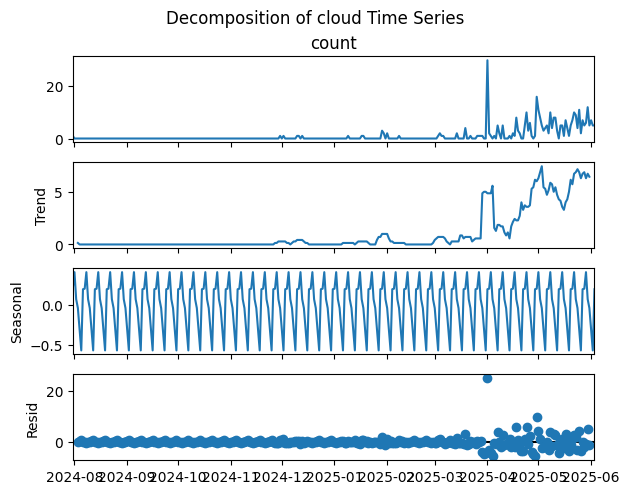

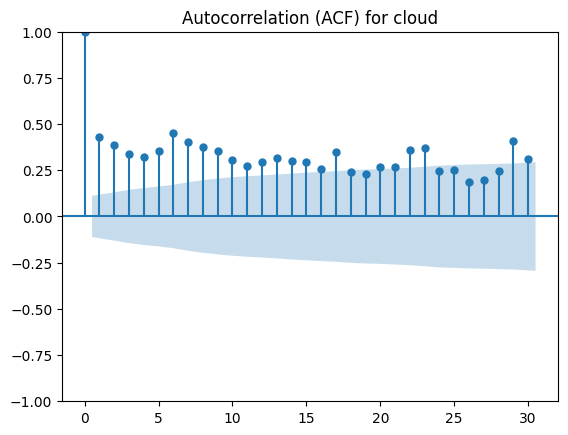

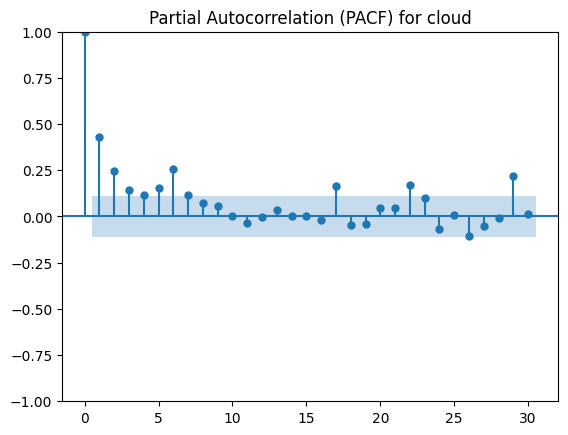

In [6]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

skill = top_skills[0]  # Cambia por la habilidad que quieras analizar
skill_ts = (
    skill_counts[skill_counts['skills_list'] == skill]
    .set_index('created_date')['count']
    .asfreq('D', fill_value=0)
    .sort_index()
)

# Descomposición de la serie de tiempo
decomposition = seasonal_decompose(skill_ts, model='additive', period=7)
decomposition.plot()
plt.suptitle(f"Decomposition of {skill} Time Series", y=1.02)
plt.show()

# Autocorrelación y autocorrelación parcial
plot_acf(skill_ts, lags=30)
plt.title(f"Autocorrelation (ACF) for {skill}")
plt.show()

plot_pacf(skill_ts, lags=30)
plt.title(f"Partial Autocorrelation (PACF) for {skill}")
plt.show()